In [1]:
#%% Import libraries
import numpy as np
from sympy import *
from sympy.physics.vector import dynamicsymbols
import control as ctl
import matplotlib.pyplot as plt
# from sympy.physics.mechanics import ReferenceFrame
from IPython.display import display, Latex, Math
init_printing(use_latex='mathjax')

from sys import path
path.append(
    "c:\\Users\\diego\\Dropbox\\Academic\\MEng Space Systems\\3. DOCA\\ADCS functions")
import ADCS_Functions as adcs
import ADCS_Functions_sym as adcs_sym

________________

Consider the spacecraft attitude control problem for a single axis. Neglecting 
the disturbance torque, the attitude dynamics are given by:

$I\ddot{\theta} = u$

where $u$ is the control torque. The moment of inertia is $I=1 \mathrm{kg.m^2}$.The following transient specifications are given for the closed-loop step response:

* Maximum overshoot requirement, $M_p = 20\%$
* Maximum settling time requirement, $t_s = 60s$

Design a modified proportional-derivative attitude control law such that the 
transient specifications are satisfied

In [2]:
I = 1    # kg m^2
Mp = 0.2 # %
ts = 60  # s 

_____________

In [3]:
theta_sym = dynamicsymbols('theta')
I_sym, u_sym, xi_sym, omega_nsym = symbols('I u xi \omega_n')

eq = diff(diff(theta_sym)) * I_sym - u_sym
eq

    2          
   d           
I⋅───(θ(t)) - u
    2          
  dt           

______________________

In [4]:
TF = adcs_sym.close_loop_TF()
TF

                  2          
           \omegaₙ           
─────────────────────────────
       2                    2
\omegaₙ  + 2⋅\omegaₙ⋅s⋅ξ + s 

In [5]:
def xiomega_n(ts):
    """
    Use for closed-loop system only.

    Returns the product of the undamped natural frequency (omega) and the damping ratio (xi).
    Calculated from settling time formula (page 52 of ADCSX.pdf)
    """
    xi_omega_n = 4.4/ts
    return xi_omega_n

In [6]:
xiomega_n_sym = xi_sym*omega_nsym
xiomega_n = adcs.xiomega_n_f(ts)
xiomega_n, xiomega_n_sym


(0.07333333333333333, \omegaₙ⋅ξ)

In [7]:
omega_d = solve(Eq(adcs_sym.max_overshoot_CLTF(), Mp),
                Symbol('omega_d'))[0].subs(Symbol('xi')*Symbol('omega_n'), xiomega_n)
omega_d


0.143145292827619

__________________________________________

### Begin example to show what the library is capable of: (not applicable to the problem since wn is unknown still)

In [8]:
xiomega_n, omega_d, TF = adcs.close_loop_TF_solve(ts, Mp, 0.1609347)
xiomega_n, omega_d, TF


⎛                                                      0.02589997766409       
⎜0.07333333333333333, 0.143145292827619, ─────────────────────────────────────
⎜                                         2                                   
⎝                                        s  + 0.146666666666667⋅s + 0.02589997

      ⎞
──────⎟
      ⎟
766409⎠

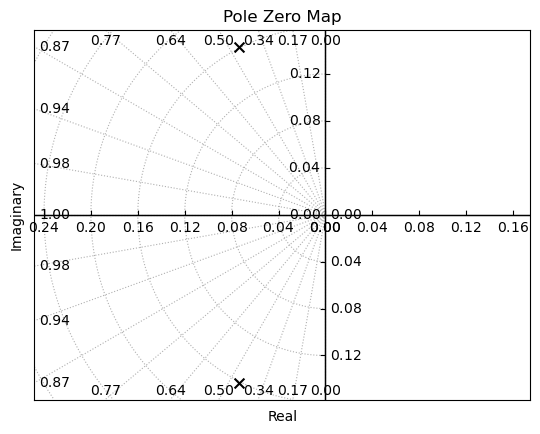

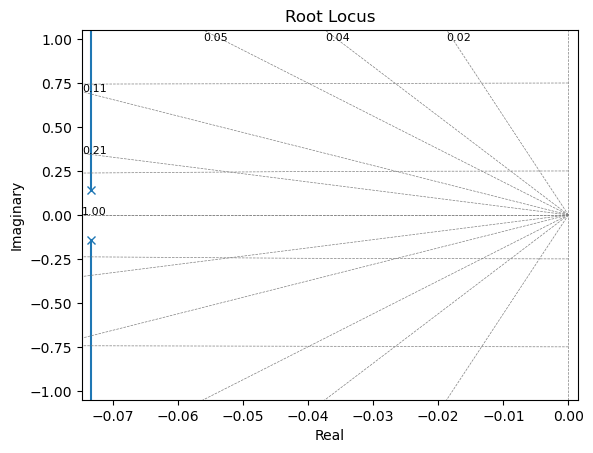

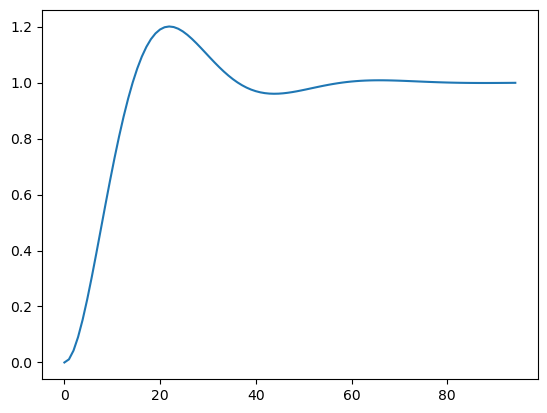

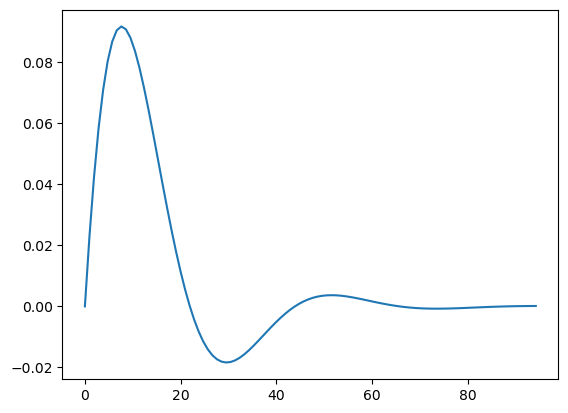

In [9]:
TF = adcs_sym.syms2tf(TF)


In [10]:
TF

TransferFunction(array([0.02589998]), array([1.        , 0.14666667, 0.02589998]))

__________________

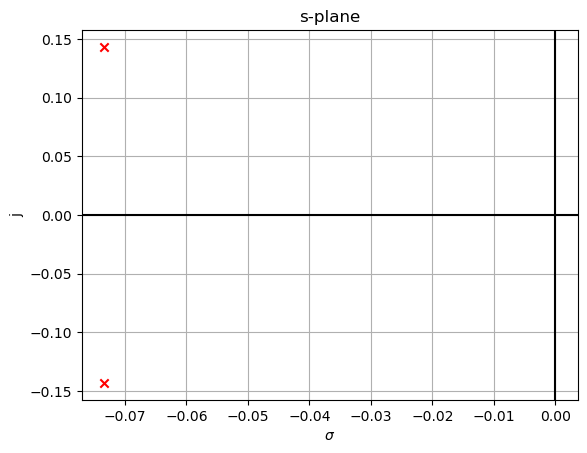

array([-0.07333333+0.14314529j, -0.07333333-0.14314529j])

In [11]:
poles = adcs.closed_loop_poles(xiomega_n, omega_d)

poles

In [12]:
Kp, Ki = adcs.PD_coefs_CL(I, poles=poles, xiomega_n=xiomega_n)
Kp, Ki


(0.025868352636482638, 0.14666666666666667)

Now i could be able to calculate $\omega_n$ from the given parameters and plot what was plotted in the example above.

Can also convert to space state and back to transfer function:

In [13]:
SS = ctl.tf2ss(TF)
SS

StateSpace(array([[-0.14666667, -0.02589998],
       [ 1.        ,  0.        ]]), array([[-0.1],
       [ 0. ]]), array([[ 0.        , -0.25899978]]), array([[0.]]))

Space state is in the form: dx/dt = A x + B u y = C x + D u

In [15]:
print(SS)

A = [[-0.14666667 -0.02589998]
     [ 1.          0.        ]]

B = [[-0.1]
     [ 0. ]]

C = [[ 0.         -0.25899978]]

D = [[0.]]



In [14]:
ctl.ss2tf(SS)

TransferFunction(array([0.02589998]), array([1.        , 0.14666667, 0.02589998]))